In [15]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from chromosome import Chromosome 
from data_preprocessing import Data
from single_data_processing import SingleAssetTI
import itertools
import yfinance as yf
from pso import PortfolioPSO
from model_comparator import ModelComparator
from island_ga import IslandGGA
from single_data_processing import SingleAssetTI
from diversified_strategies import DiversifiedTradingStrategies
import datetime

[*********************100%***********************]  1 of 1 completed


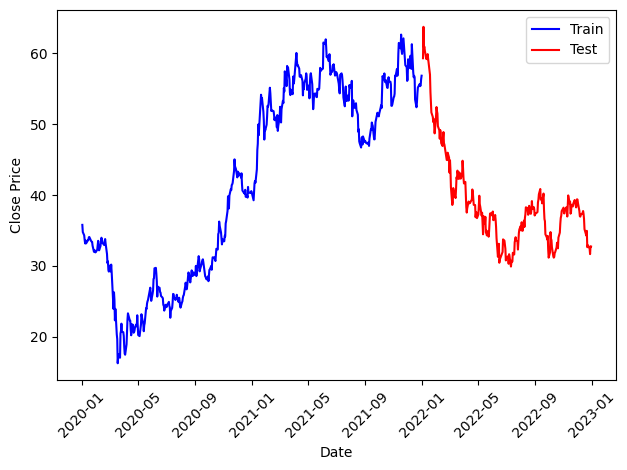

In [4]:
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period ="train"
ticker = 'GM'
data = SingleAssetTI(ticker, start_date, end_date,2022)
data.data_preprocess()
train_data = data.train_data    
val_data = data.test_data

In [16]:
## Multi stock experiment
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period =2022
tickers = [
        # Large cap stocks
        'AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN',
        # Different sectors
        'JPM', 'JNJ', 'PG', 'XOM', 'WMT',
        # ETFs for broader exposure
        'SPY', 'QQQ', 'IWM', 'EFA', 'GLD'
    ]

diversified_system = DiversifiedTradingStrategies(
            tickers=tickers,
            start_date=start_date,
            end_date=end_date,
            test_period=period
        )
    
# Generate training returns
print("Generating diversified training and tesing strategies...")
train_data, val_data = diversified_system.generate_diversified_returns(is_training=True)
strategies = diversified_system.strategy_names

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Loaded AAPL: 756 records
Loaded MSFT: 756 records


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Loaded GOOGL: 756 records



[*********************100%***********************]  1 of 1 completed


Loaded TSLA: 756 records
Loaded AMZN: 756 records


[*********************100%***********************]  1 of 1 completed


Loaded JPM: 756 records


[*********************100%***********************]  1 of 1 completed


Loaded JNJ: 756 records


[*********************100%***********************]  1 of 1 completed


Loaded PG: 756 records


[*********************100%***********************]  1 of 1 completed


Loaded XOM: 756 records


[*********************100%***********************]  1 of 1 completed


Loaded WMT: 756 records


[*********************100%***********************]  1 of 1 completed


Loaded SPY: 756 records


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Loaded QQQ: 756 records
Loaded IWM: 756 records


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Loaded EFA: 756 records
Loaded GLD: 756 records
Generating diversified training and tesing strategies...


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

evolve_strategy = ["ring", "multikuti", "master_slave", "gga"]
num_runs = 10
all_records = []

for strategy in evolve_strategy:
    if strategy == 'gga':
        num_islands = 1
        pop_size = 200
    else:
        num_islands = 5
        pop_size = 200

    for run in range(num_runs):
                     
        
        ga = IslandGGA(
            data=train_data,
            K=19,
            num_islands=num_islands,
            m_iter=5,
            num_iter=50,
            n_migrants_rate=0.25,
            pSize=pop_size,
            strategies=strategies,
            evolve_strategy=strategy
        )
        ga.evolve()
        #convergence = ga.convergence_times  # assume it's a list of values over time
        fitness_values= ga.convergence_values

        for t, val in enumerate(fitness_values, start=1):
            all_records.append({
                'strategy': strategy,
                'run': run,
                'iteration': t,
                'value': val
            })
 
# Convert to DataFrame
df_convergence = pd.DataFrame(all_records)

# Save for inspection
df_convergence.to_csv("results/diversified/convergence.csv", index=False)


Initialized with 5 max workers for 5 islands
Running ring with 5 workers
System: CPU 22.9%, Memory 79.8%
Generation 1: Best fitness = 3.247915  Average Fitness = 1.634272
Generation 2: Best fitness = 3.247915  Average Fitness = 2.419469
Generation 3: Best fitness = 3.247915  Average Fitness = 2.581753


In [18]:
df_convergence.groupby(['strategy'])[['value']].mean().round(4)

,value
strategy,
gga,3.3342
master_slave,3.3678
multikuti,2.5981
ring,3.1671


Convergence Analysis with Statistical Measures


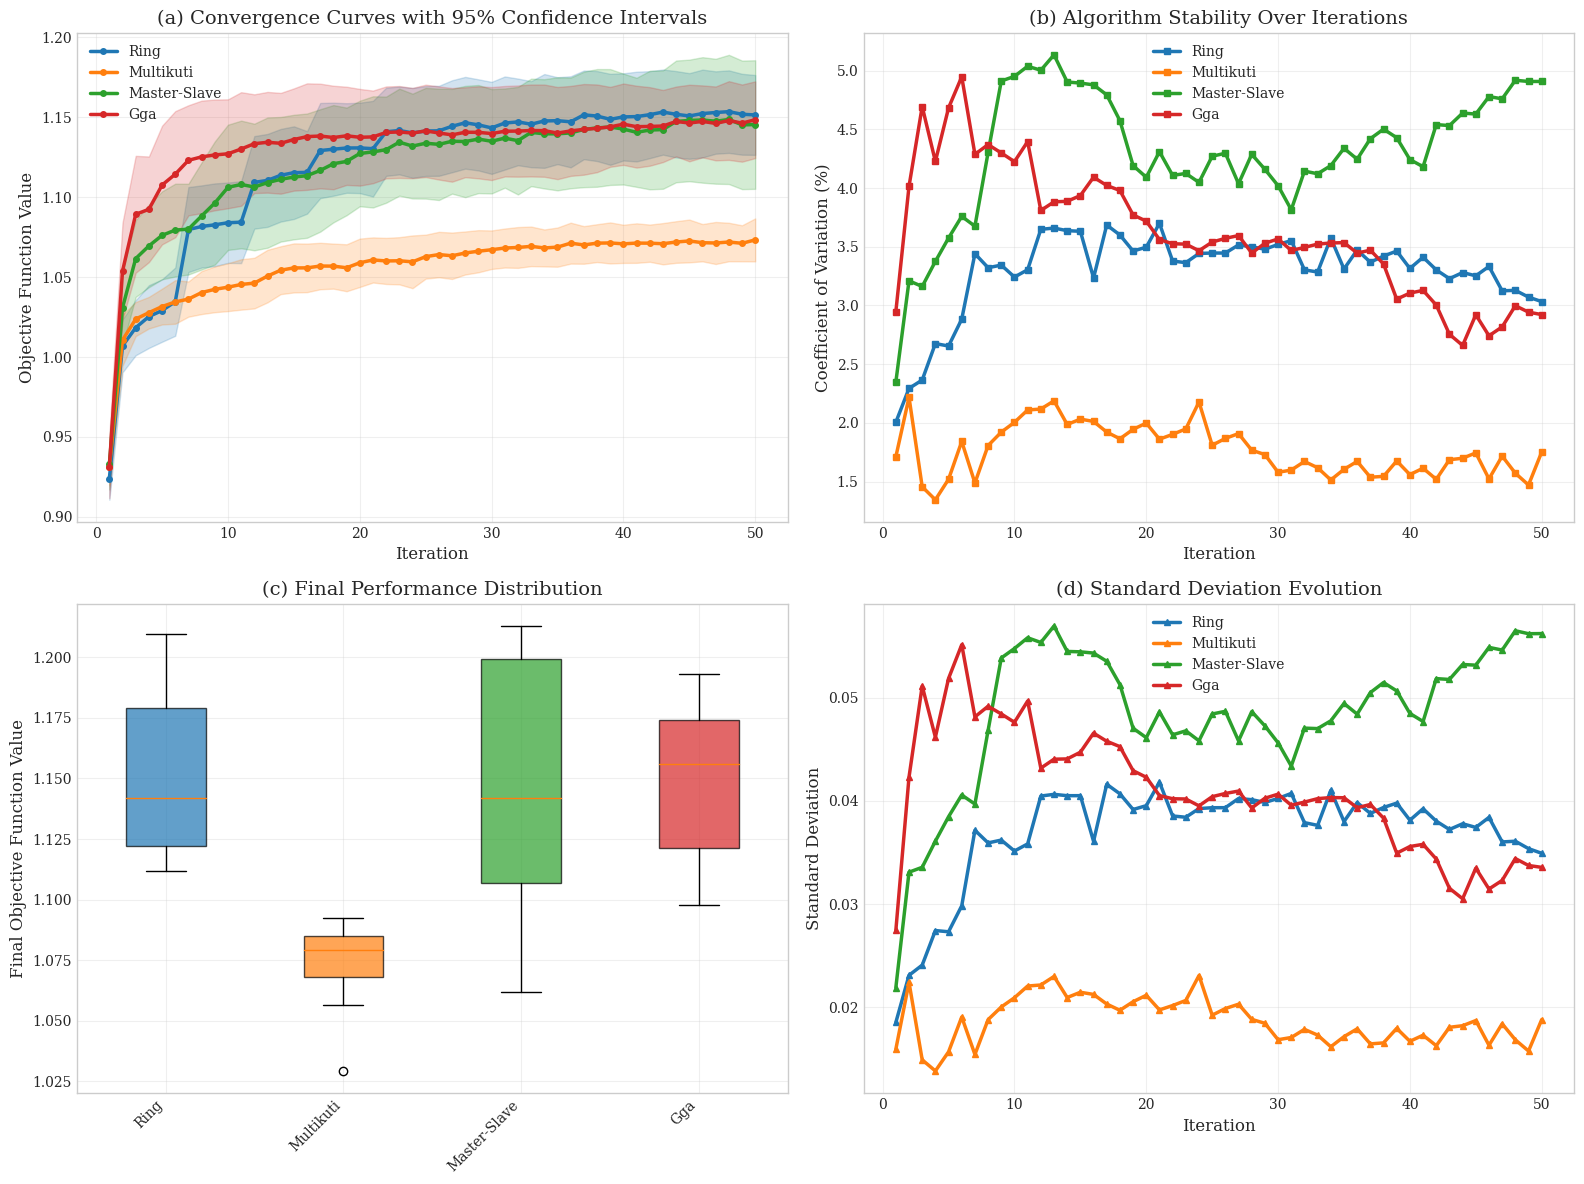

LaTeX Table for Paper:
\begin{table}[htbp]
\centering
\caption{Convergence and Stability Analysis Summary}
\label{tab:convergence_stats}
\begin{tabular}{lccccc}
\hline
Algorithm & Mean CV (\%) & Convergence Rate & Stability Trend & Final Mean & 95\% CI \\
\hline
Ring & 3.29 & 0.005 & 0.40 & 1.15 & [1.13, 1.18] \\
Multikuti & 1.77 & 0.003 & -0.11 & 1.07 & [1.06, 1.09] \\
Master-Slave & 4.31 & 0.004 & 0.91 & 1.15 & [1.11, 1.19] \\
Gga & 3.61 & 0.004 & -1.36 & 1.15 & [1.12, 1.17] \\
\hline
\end{tabular}
\end{table}

Summary Statistics DataFrame:
   Algorithm Mean CV (%) Convergence Rate Stability Trend Final Mean Final 95% CI
        Ring        3.29            0.005            0.40       1.15 [1.13, 1.18]
   Multikuti        1.77            0.003           -0.11       1.07 [1.06, 1.09]
Master-Slave        4.31            0.004            0.91       1.15 [1.11, 1.19]
         Gga        3.61            0.004           -1.36       1.15 [1.12, 1.17]

Statistical Significance Tests:
One-way 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t
import warnings
warnings.filterwarnings('ignore')

# Set publication-ready style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'font.family': 'serif'
})


from io import StringIO
df = pd.read_csv("results/convergence_all_runs.csv")

def calculate_statistics(df):
    """Calculate comprehensive statistics for convergence analysis"""
    stats_list = []
    
    for strategy in df['strategy'].unique():
        for iteration in df['iteration'].unique():
            subset = df[(df['strategy'] == strategy) & (df['iteration'] == iteration)]
            values = subset['value'].values
            
            n = len(values)
            mean = np.mean(values)
            std = np.std(values, ddof=1)  # sample standard deviation
            var = np.var(values, ddof=1)   # sample variance
            sem = std / np.sqrt(n)         # standard error of mean
            
            # 95% confidence interval using t-distribution
            alpha = 0.05
            t_val = t.ppf(1 - alpha/2, n-1)
            ci_lower = mean - t_val * sem
            ci_upper = mean + t_val * sem
            
            # Coefficient of variation
            cv = (std / mean) * 100 if mean != 0 else 0
            
            stats_list.append({
                'strategy': strategy,
                'iteration': iteration,
                'mean': mean,
                'std': std,
                'var': var,
                'sem': sem,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'cv': cv,
                'n': n
            })
    
    return pd.DataFrame(stats_list)

# Calculate statistics
stats_df = calculate_statistics(df)

# Create publication-ready plots
def create_convergence_plots():
    """Create comprehensive convergence analysis plots"""
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # Define colors for each strategy
    colors = {
        'ring': '#1f77b4',
        'multikuti': '#ff7f0e', 
        'master_slave': '#2ca02c',
        'gga': '#d62728'
    }
    
    # Plot 1: Mean convergence with confidence intervals
    ax1 = plt.subplot(2, 2, 1)
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy].sort_values('iteration')
        
        # Plot mean line
        ax1.plot(strategy_data['iteration'], strategy_data['mean'], 
                color=colors[strategy], linewidth=2.5, 
                label=strategy.replace('_', '-').title(), marker='o', markersize=4)
        
        # Add confidence interval
        ax1.fill_between(strategy_data['iteration'], 
                        strategy_data['ci_lower'], 
                        strategy_data['ci_upper'],
                        alpha=0.2, color=colors[strategy])
    
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Objective Function Value')
    ax1.set_title('(a) Convergence Curves with 95% Confidence Intervals')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Coefficient of Variation (Stability measure)
    ax2 = plt.subplot(2, 2, 2)
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy].sort_values('iteration')
        ax2.plot(strategy_data['iteration'], strategy_data['cv'], 
                color=colors[strategy], linewidth=2.5, 
                label=strategy.replace('_', '-').title(), marker='s', markersize=4)
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Coefficient of Variation (%)')
    ax2.set_title('(b) Algorithm Stability Over Iterations')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Box plots for final iteration (convergence quality)
    ax3 = plt.subplot(2, 2, 3)
    final_data = df[df['iteration'] == 50]
    strategies = final_data['strategy'].unique()
    
    box_data = []
    labels = []
    for strategy in strategies:
        values = final_data[final_data['strategy'] == strategy]['value'].values
        box_data.append(values)
        labels.append(strategy.replace('_', '-').title())
    
    bp = ax3.boxplot(box_data, labels=labels, patch_artist=True)
    for patch, strategy in zip(bp['boxes'], strategies):
        patch.set_facecolor(colors[strategy])
        patch.set_alpha(0.7)
    
    ax3.set_ylabel('Final Objective Function Value')
    ax3.set_title('(c) Final Performance Distribution')
    ax3.grid(True, alpha=0.3)
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
    
    # Plot 4: Standard deviation evolution
    ax4 = plt.subplot(2, 2, 4)
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy].sort_values('iteration')
        ax4.plot(strategy_data['iteration'], strategy_data['std'], 
                color=colors[strategy], linewidth=2.5, 
                label=strategy.replace('_', '-').title(), marker='^', markersize=4)
    
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Standard Deviation')
    ax4.set_title('(d) Standard Deviation Evolution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('convergence_analysis.png', dpi=300, bbox_inches='tight')
    plt.savefig('convergence_analysis.pdf', bbox_inches='tight')
    plt.show()

def create_summary_table():
    """Create summary statistics table"""
    
    # Calculate summary statistics
    summary_stats = []
    
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy]
        
        # Mean CV across all iterations (overall stability)
        mean_cv = strategy_data['cv'].mean()
        
        # Convergence rate (improvement from iter 1 to 10)
        iter1_mean = strategy_data[strategy_data['iteration'] == 1]['mean'].iloc[0]
        iter10_mean = strategy_data[strategy_data['iteration'] == 50]['mean'].iloc[0]
        convergence_rate = (iter10_mean - iter1_mean) / 50
        
        # Final performance statistics
        final_stats = strategy_data[strategy_data['iteration'] == 50].iloc[0]
        
        # Stability trend (early vs late CV)
        early_cv = strategy_data[strategy_data['iteration'] <= 10]['cv'].mean()
        late_cv = strategy_data[strategy_data['iteration'] >= 40]['cv'].mean()
        stability_trend = late_cv - early_cv
        
        summary_stats.append({
            'Algorithm': strategy.replace('_', '-').title(),
            'Mean CV (%)': f"{mean_cv:.2f}",
            'Convergence Rate': f"{convergence_rate:.3f}",
            'Stability Trend': f"{stability_trend:.2f}",
            'Final Mean': f"{final_stats['mean']:.2f}",
            'Final 95% CI': f"[{final_stats['ci_lower']:.2f}, {final_stats['ci_upper']:.2f}]"
        })
    
    summary_df = pd.DataFrame(summary_stats)
    
    # Print LaTeX table
    print("LaTeX Table for Paper:")
    print("\\begin{table}[htbp]")
    print("\\centering")
    print("\\caption{Convergence and Stability Analysis Summary}")
    print("\\label{tab:convergence_stats}")
    print("\\begin{tabular}{lccccc}")
    print("\\hline")
    print("Algorithm & Mean CV (\\%) & Convergence Rate & Stability Trend & Final Mean & 95\\% CI \\\\")
    print("\\hline")
    
    for _, row in summary_df.iterrows():
        print(f"{row['Algorithm']} & {row['Mean CV (%)']} & {row['Convergence Rate']} & {row['Stability Trend']} & {row['Final Mean']} & {row['Final 95% CI']} \\\\")
    
    print("\\hline")
    print("\\end{tabular}")
    print("\\end{table}")
    print()
    
    return summary_df

def perform_statistical_tests():
    """Perform statistical significance tests"""
    
    print("Statistical Significance Tests:")
    print("="*50)
    
    # ANOVA test for final iteration differences
    final_data = df[df['iteration'] == 50]
    groups = []
    for strategy in final_data['strategy'].unique():
        values = final_data[final_data['strategy'] == strategy]['value'].values
        groups.append(values)
    
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"One-way ANOVA (final iteration):")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print("Significant differences detected between algorithms (p < 0.05)")
        
        # Pairwise t-tests with Bonferroni correction
        from itertools import combinations
        strategies = final_data['strategy'].unique()
        n_comparisons = len(list(combinations(strategies, 2)))
        alpha_corrected = 0.05 / n_comparisons
        
        print(f"\nPairwise t-tests (Bonferroni corrected α = {alpha_corrected:.4f}):")
        
        for s1, s2 in combinations(strategies, 2):
            group1 = final_data[final_data['strategy'] == s1]['value'].values
            group2 = final_data[final_data['strategy'] == s2]['value'].values
            
            t_stat, p_val = stats.ttest_ind(group1, group2)
            significant = "***" if p_val < alpha_corrected else ""
            
            print(f"{s1} vs {s2}: t={t_stat:.3f}, p={p_val:.6f} {significant}")
    
    print()

# Main execution
if __name__ == "__main__":
    print("Convergence Analysis with Statistical Measures")
    print("="*50)
    
    # Create plots
    create_convergence_plots()
    
    # Create summary table
    summary_df = create_summary_table()
    print("Summary Statistics DataFrame:")
    print(summary_df.to_string(index=False))
    print()
    
    # Perform statistical tests
    perform_statistical_tests()
    
    print("Analysis complete! Files saved:")
    print("- convergence_analysis.png (high-resolution figure)")
    print("- convergence_analysis.pdf (vector format)")

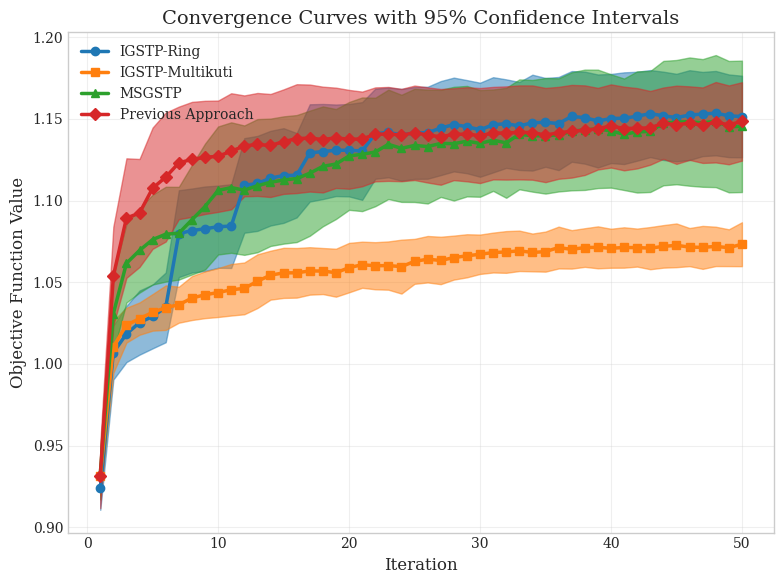

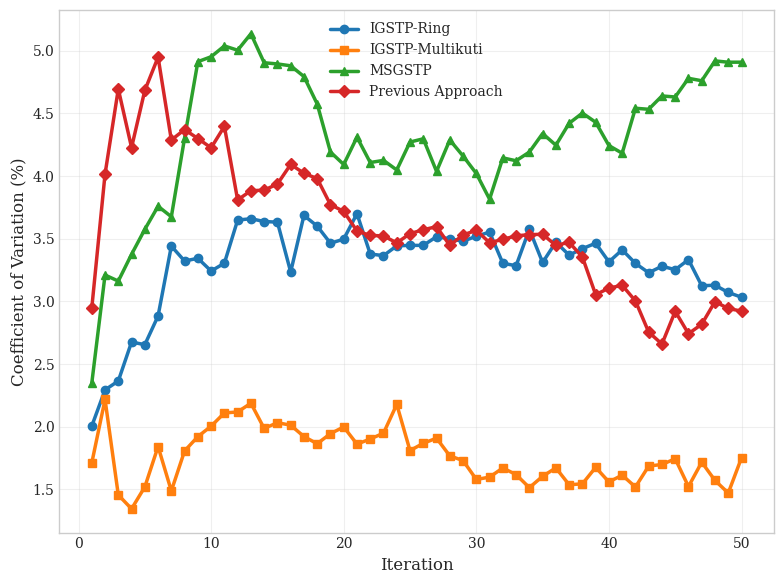

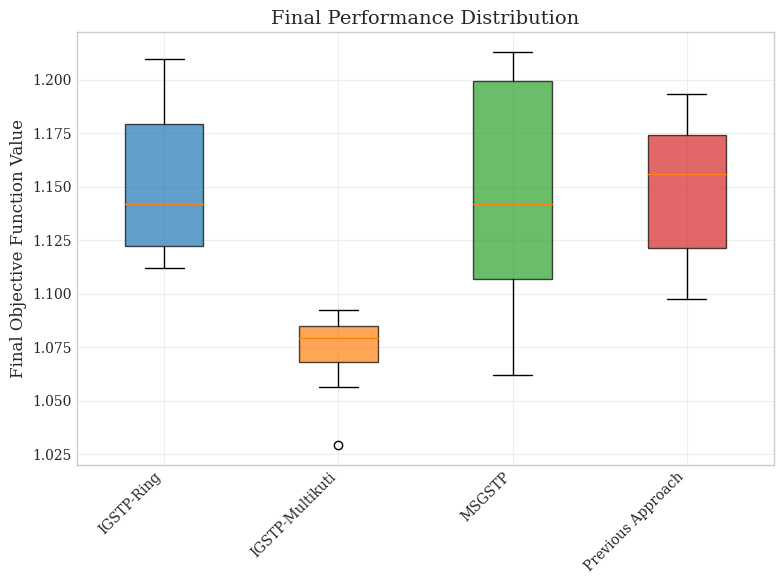

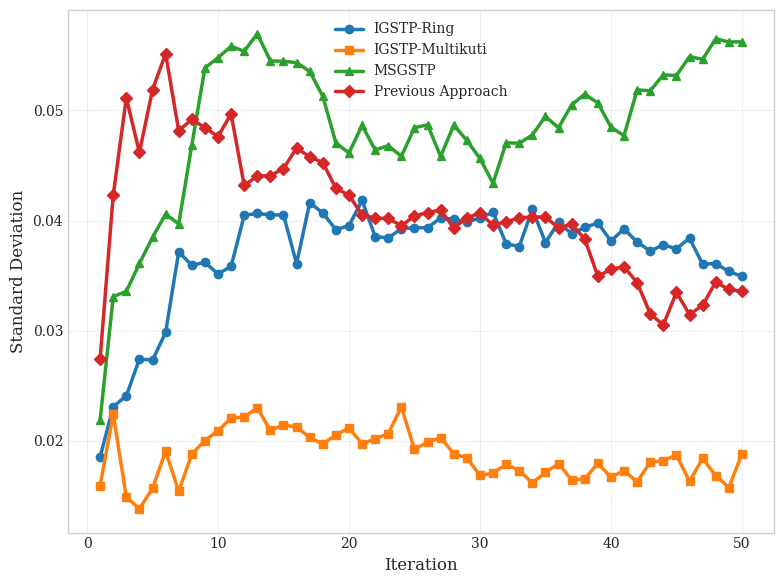

In [24]:
def create_convergence_plots():
    """Create standalone convergence analysis plots with custom labels and distinct markers"""
    
    # Strategy label mapping
    label_map = {
        'gga': 'Previous Approach',
        'ring': 'IGSTP-Ring',
        'multikuti': 'IGSTP-Multikuti',
        'master_slave': 'MSGSTP'
    }

    # Colors for strategies
    colors = {
        'ring': '#1f77b4',
        'multikuti': '#ff7f0e', 
        'master_slave': '#2ca02c',
        'gga': '#d62728'
    }

    # Distinct markers for each strategy
    marker_map = {
        'ring': 'o',
        'multikuti': 's',
        'master_slave': '^',
        'gga': 'D'
    }

    # 1. Mean convergence with confidence intervals
    plt.figure(figsize=(8,6))
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy].sort_values('iteration')
        plt.plot(strategy_data['iteration'], strategy_data['mean'],
                 color=colors[strategy], linewidth=2.5,
                 label=label_map[strategy], marker=marker_map[strategy], markersize=6)
        plt.fill_between(strategy_data['iteration'], strategy_data['ci_lower'], strategy_data['ci_upper'],
                         alpha=0.5, color=colors[strategy])
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.title('Convergence Curves with 95% Confidence Intervals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Coefficient of Variation (Stability)
    plt.figure(figsize=(8,6))
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy].sort_values('iteration')
        plt.plot(strategy_data['iteration'], strategy_data['cv'],
                 color=colors[strategy], linewidth=2.5,
                 label=label_map[strategy], marker=marker_map[strategy], markersize=6)
    plt.xlabel('Iteration')
    plt.ylabel('Coefficient of Variation (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. Box plots for final iteration
    plt.figure(figsize=(8,6))
    final_data = df[df['iteration'] == 50]
    strategies = final_data['strategy'].unique()
    box_data = []
    labels = []
    for strategy in strategies:
        values = final_data[final_data['strategy'] == strategy]['value'].values
        box_data.append(values)
        labels.append(label_map[strategy])
    bp = plt.boxplot(box_data, labels=labels, patch_artist=True)
    for patch, strategy in zip(bp['boxes'], strategies):
        patch.set_facecolor(colors[strategy])
        patch.set_alpha(0.7)
    plt.ylabel('Final Objective Function Value')
    plt.title('Final Performance Distribution')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('plot_final_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Standard deviation evolution
    plt.figure(figsize=(8,6))
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy].sort_values('iteration')
        plt.plot(strategy_data['iteration'], strategy_data['std'],
                 color=colors[strategy], linewidth=2.5,
                 label=label_map[strategy], marker=marker_map[strategy], markersize=6)
    plt.xlabel('Iteration')
    plt.ylabel('Standard Deviation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
create_convergence_plots()
